In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import itertools
import pingouin as pg
import seaborn as sns
import nibabel as nib


from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
from scipy.cluster.hierarchy import (linkage, optimal_leaf_ordering, leaves_list, dendrogram)
simplefilter("ignore", ClusterWarning)
simplefilter(action='ignore', category=FutureWarning)

In [2]:
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels.csv')
ages = pd.read_csv('../../DerivedData/all3groups_with_ages.csv', index_col=0)
ages.rename(columns={'subject': 'subject_id' ,
                     'session' : 'session_id'}, inplace=True)
rois = relabeled_encoding['new_label'].values
groups = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
df = pd.read_csv('../../Results/extracted_metrics/ROIs_median_diffusion.csv')
metrics=['FA', 'L1', 'RD', 'MD', 'OD', 'NDI']
df = pd.merge(df, ages, on=['session_id', 'subject_id'])

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
global_GM = {}
for metric in metrics:
    cols = ['{}_{}'.format(roi,metric) for roi in rois]
    global_GM[metric] = np.median( df[cols].values, axis=1)
    
for metric in metrics:
    df['global_{}'.format(metric)] =  global_GM[metric]

In [4]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5) 

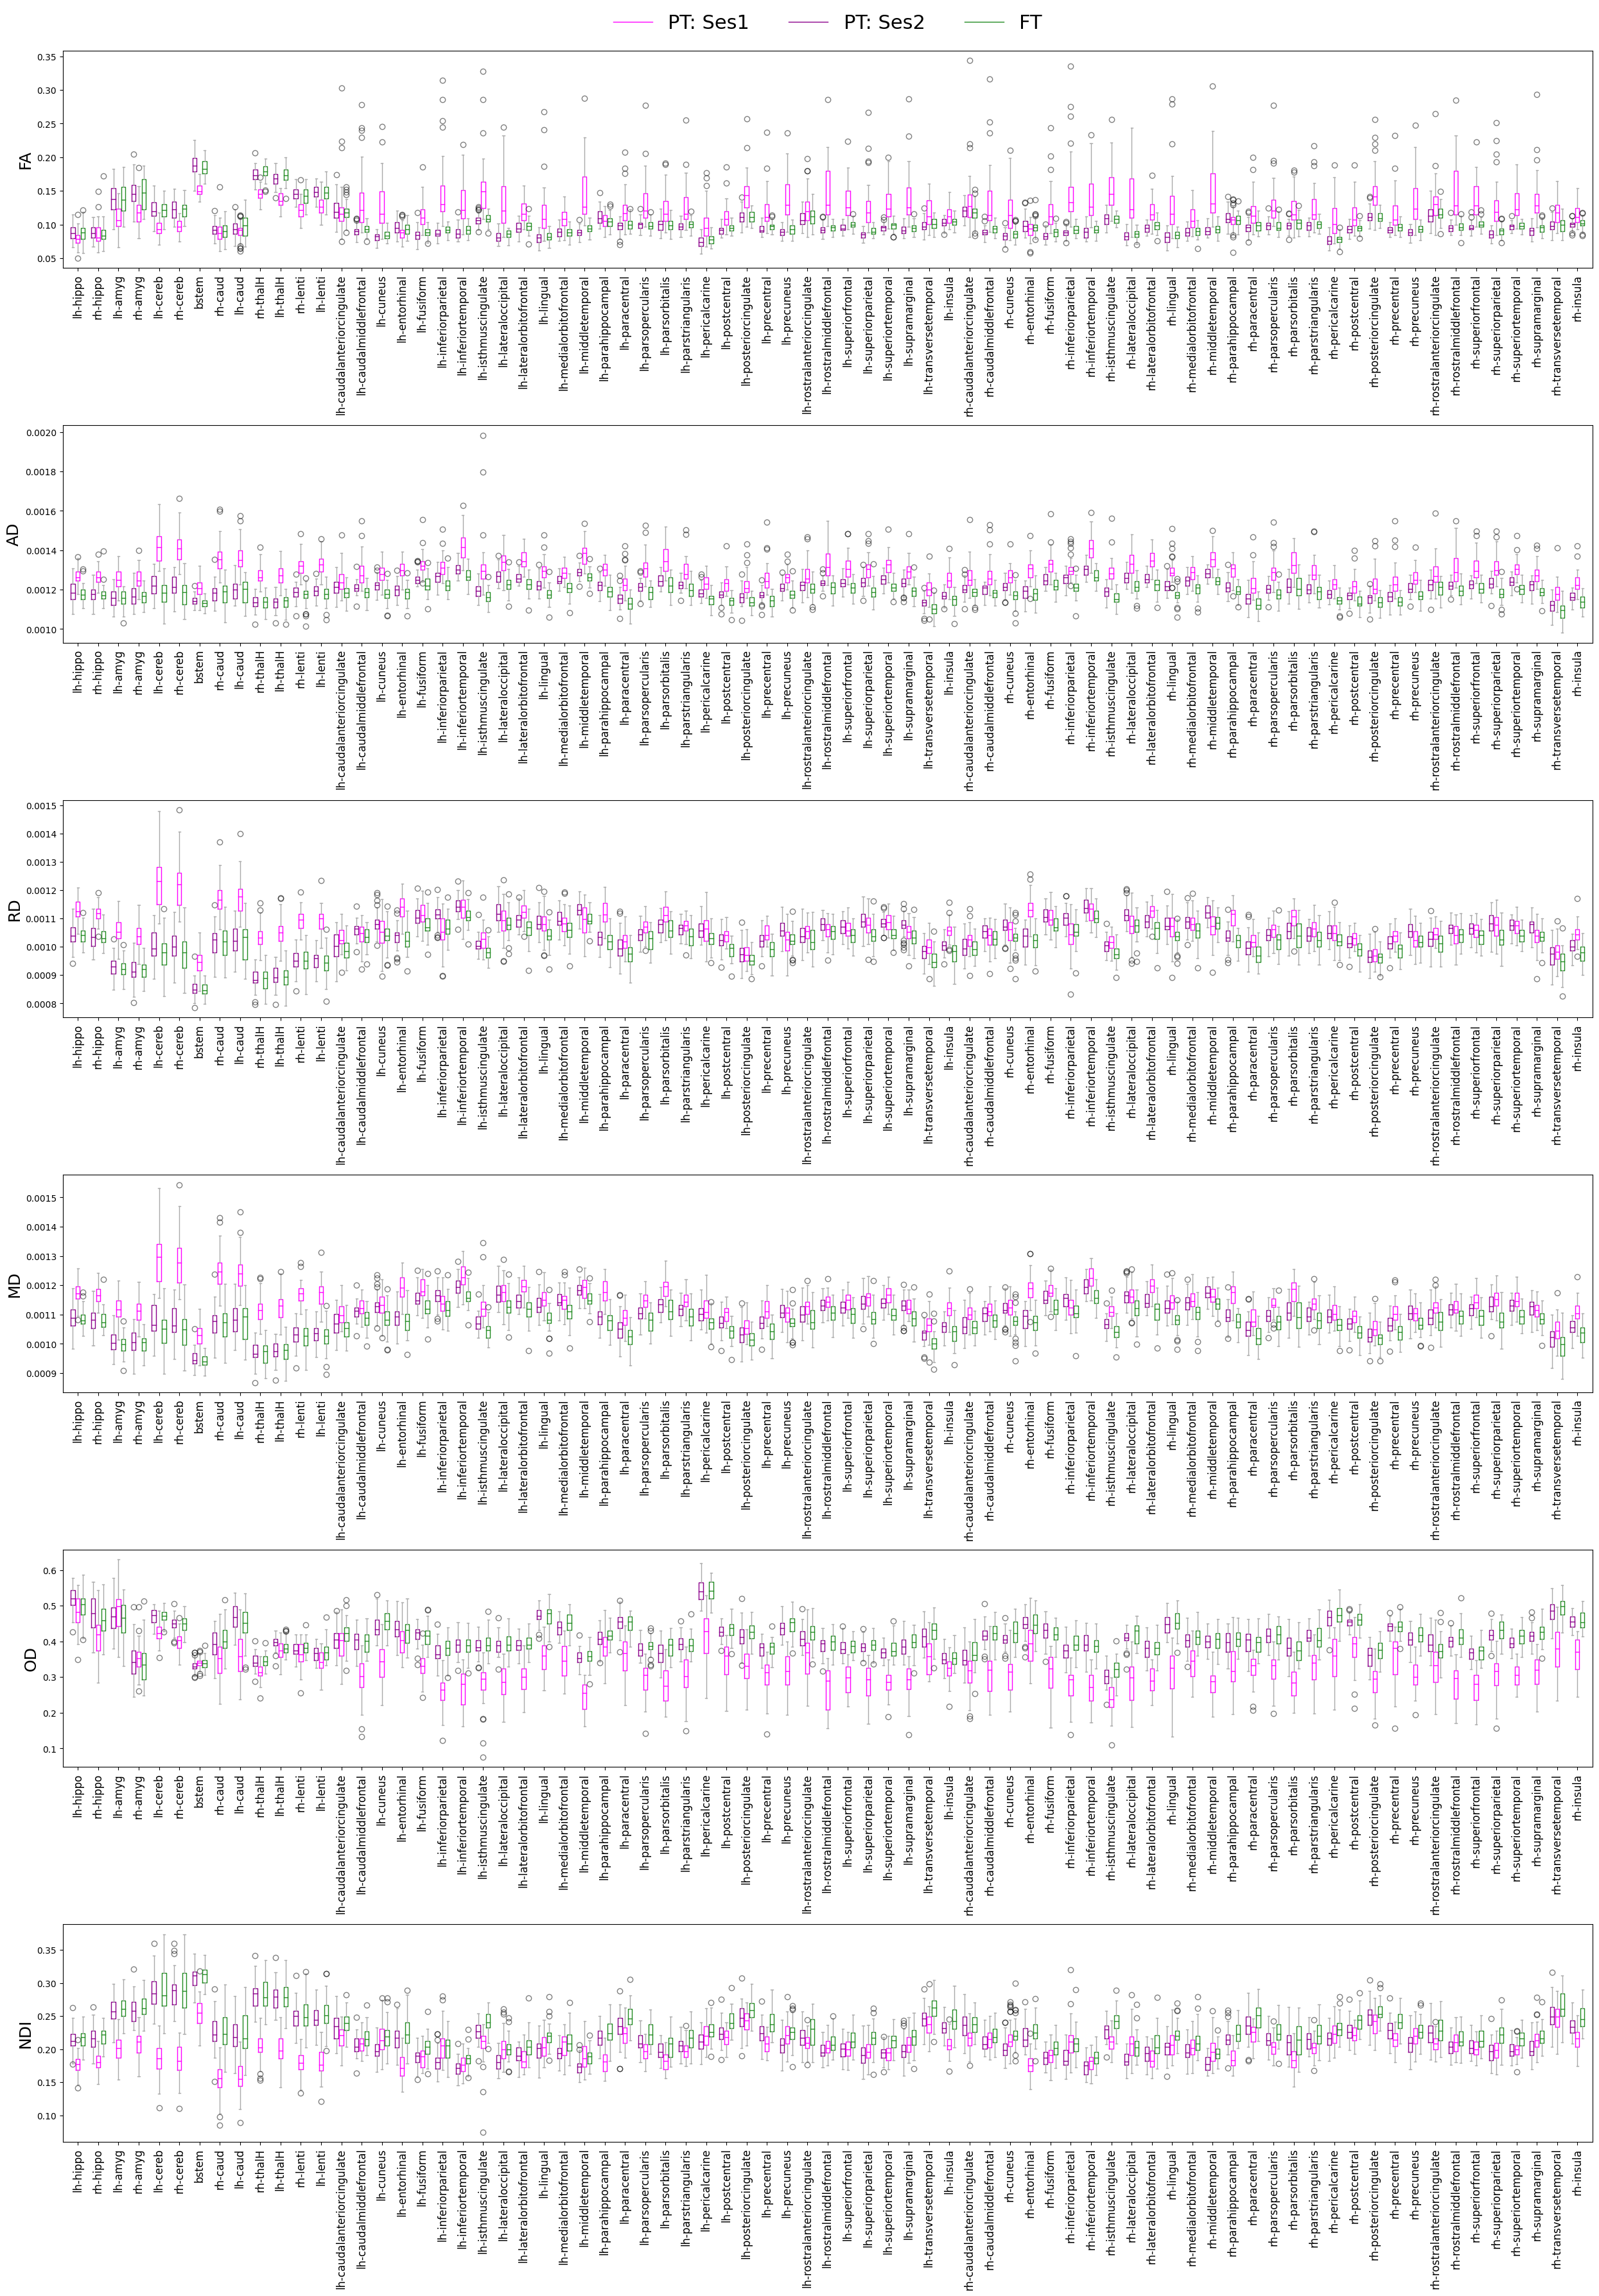

In [13]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(25, len(metrics*6)))

#plt.figure(figsize=(25,6))
for i, roi in enumerate(rois):
    for r, metric in enumerate(metrics):
        
      
        g1 = axs[r].boxplot(df[df.session_id.isin(groups['PT_session2_id'].values)]['{}_{}'.format(roi,metric)].values, positions=[i-0.25], widths=0.2 )
        set_box_color(g1, 'darkmagenta')
        g2 = axs[r].boxplot(df[df.session_id.isin(groups['PT_session1_id'].values)]['{}_{}'.format(roi,metric)].values, positions=[i], widths=0.2)
        set_box_color(g2, 'magenta')
        g3 = axs[r].boxplot(df[df.session_id.isin(groups['FT_session_id'].values)]['{}_{}'.format(roi,metric)].values, positions=[i+0.25], widths=0.2)
        set_box_color(g3, 'forestgreen')
            
        axs[r].set_xticks(np.arange(len(rois)), relabeled_encoding['ROI'].values, rotation=90, fontsize=12) 
        
        if metric == 'L1':
            metric = 'AD'
        axs[r].set_ylabel(metric, fontsize=18)
        
axs[0].legend([g2["boxes"][0], g1["boxes"][0], g3["boxes"][0]], ['PT: Ses1', 'PT: Ses2', 'FT'], 
              loc='upper center', fontsize=22, ncol=3, bbox_to_anchor=[0.5, 1.25], frameon=False)


        
plt.tight_layout()
plt.savefig('../../Results/figures/GM_correlome/regional_diffusion_3groups.jpg', dpi=300)
plt.show()

### prepare for ANCOVA 
uncorrected -> to be compared for group and tract effects

In [14]:
for group, label, cat in zip(['PT_session2_id', 'PT_session1_id', 'FT_session_id'], ['PT: Ses2', 'PT: Ses1', 'FT' ], 
                            [0,1,2]):
    df.loc[df.session_id.isin(groups[group].values), 'group'] = label
    df.loc[df.session_id.isin(groups[group].values), 'group_label'] = cat

In [15]:
test = df.copy()
for metric in metrics: 
    col_names = ['{}_{}'.format(roi, metric) for roi in rois]
    sub = pd.melt(test, id_vars=['session_id'], value_vars=col_names, var_name = 'tract', value_name=metric)
    names = [v.split('_')[0] for v in sub.tract.values]
    sub['tract'] = names
    
    if metric == 'FA':
        out = sub.copy()
    else:
        out = pd.merge(out, sub, on=['session_id','tract'],)
out = pd.merge(out, df[['scan_age ', 'birth_age ', 'global_FA', 'global_L1', 
                       'global_RD', 'global_MD', 'global_OD', 'global_NDI', 'group_label', 'session_id']], on='session_id')

### pairing
new_subjid = 0
for i, row in groups.iterrows():
    out.loc[out.session_id == row['PT_session2_id'], 'pairing'] = int(new_subjid)
    out.loc[out.session_id == row['PT_session1_id'], 'pairing'] = int(new_subjid)
    out.loc[out.session_id == row['FT_session_id'], 'pairing'] = int(new_subjid)
    new_subjid +=1 
out.to_csv('../../Results/extracted_metrics/GM_paper_uncorrected_medianROI_for_ancova.csv')

Above to be run with repeated measures ANCOVA in R as for the SM paper => to see group & ROI effects (+PMA scan, GA birth + residual global metric) 
=> correct for multi comparisons <br> <br>

##### prepare for the delay comparisons 

group_label: <br>
0 - PT: Ses2 <br>
1 - PT: Ses1

In [21]:
group_dif = pd.DataFrame()

i=0
for tract in np.unique(out.tract.values):
    for pairing in np.unique(out.pairing.values):
        
        group_dif.loc[i, 'pairing'] = pairing 
        group_dif.loc[i, 'tract'] = tract    
        
        for metric in metrics: 
            ses2 = out[(out.tract== tract) & (out.pairing ==pairing) & (out.group_label == 0)]
            ses1 = out[(out.tract== tract) & (out.pairing ==pairing) & (out.group_label == 1)]
            
            group_dif.loc[i, 'scan_delay'] = ses2['scan_age '].values[0] - ses1['scan_age '].values[0]
            group_dif.loc[i, 'birth_age'] = ses1['birth_age '].values[0]
            group_dif.loc[i, 'PMA_1st'] = ses1['scan_age '].values[0]
            group_dif.loc[i, 'PMA_2nd'] = ses2['scan_age '].values[0]
            
            group_dif.loc[i, 'dif_{}'.format(metric)] = ses2[metric].values[0] - ses1[metric].values[0] 
            group_dif.loc[i, 'dif_global_{}'.format(metric)] = ses2['global_{}'.format(metric)].values[0] - ses1['global_{}'.format(metric)].values[0]
        i=i+1       


In [22]:
group_dif.to_csv('../../Results/extracted_metrics/GM_paper_uncorrected_ses2ses1_diff_for_ancova.csv')

## Plot regional session 1 vs session 2 
=> corrected for age delay

In [5]:
group_dif = pd.read_csv('../../Results/extracted_metrics/GM_paper_uncorrected_ses2ses1_diff_for_ancova.csv', index_col=0)

In [6]:
group_dif.dropna(inplace=True)

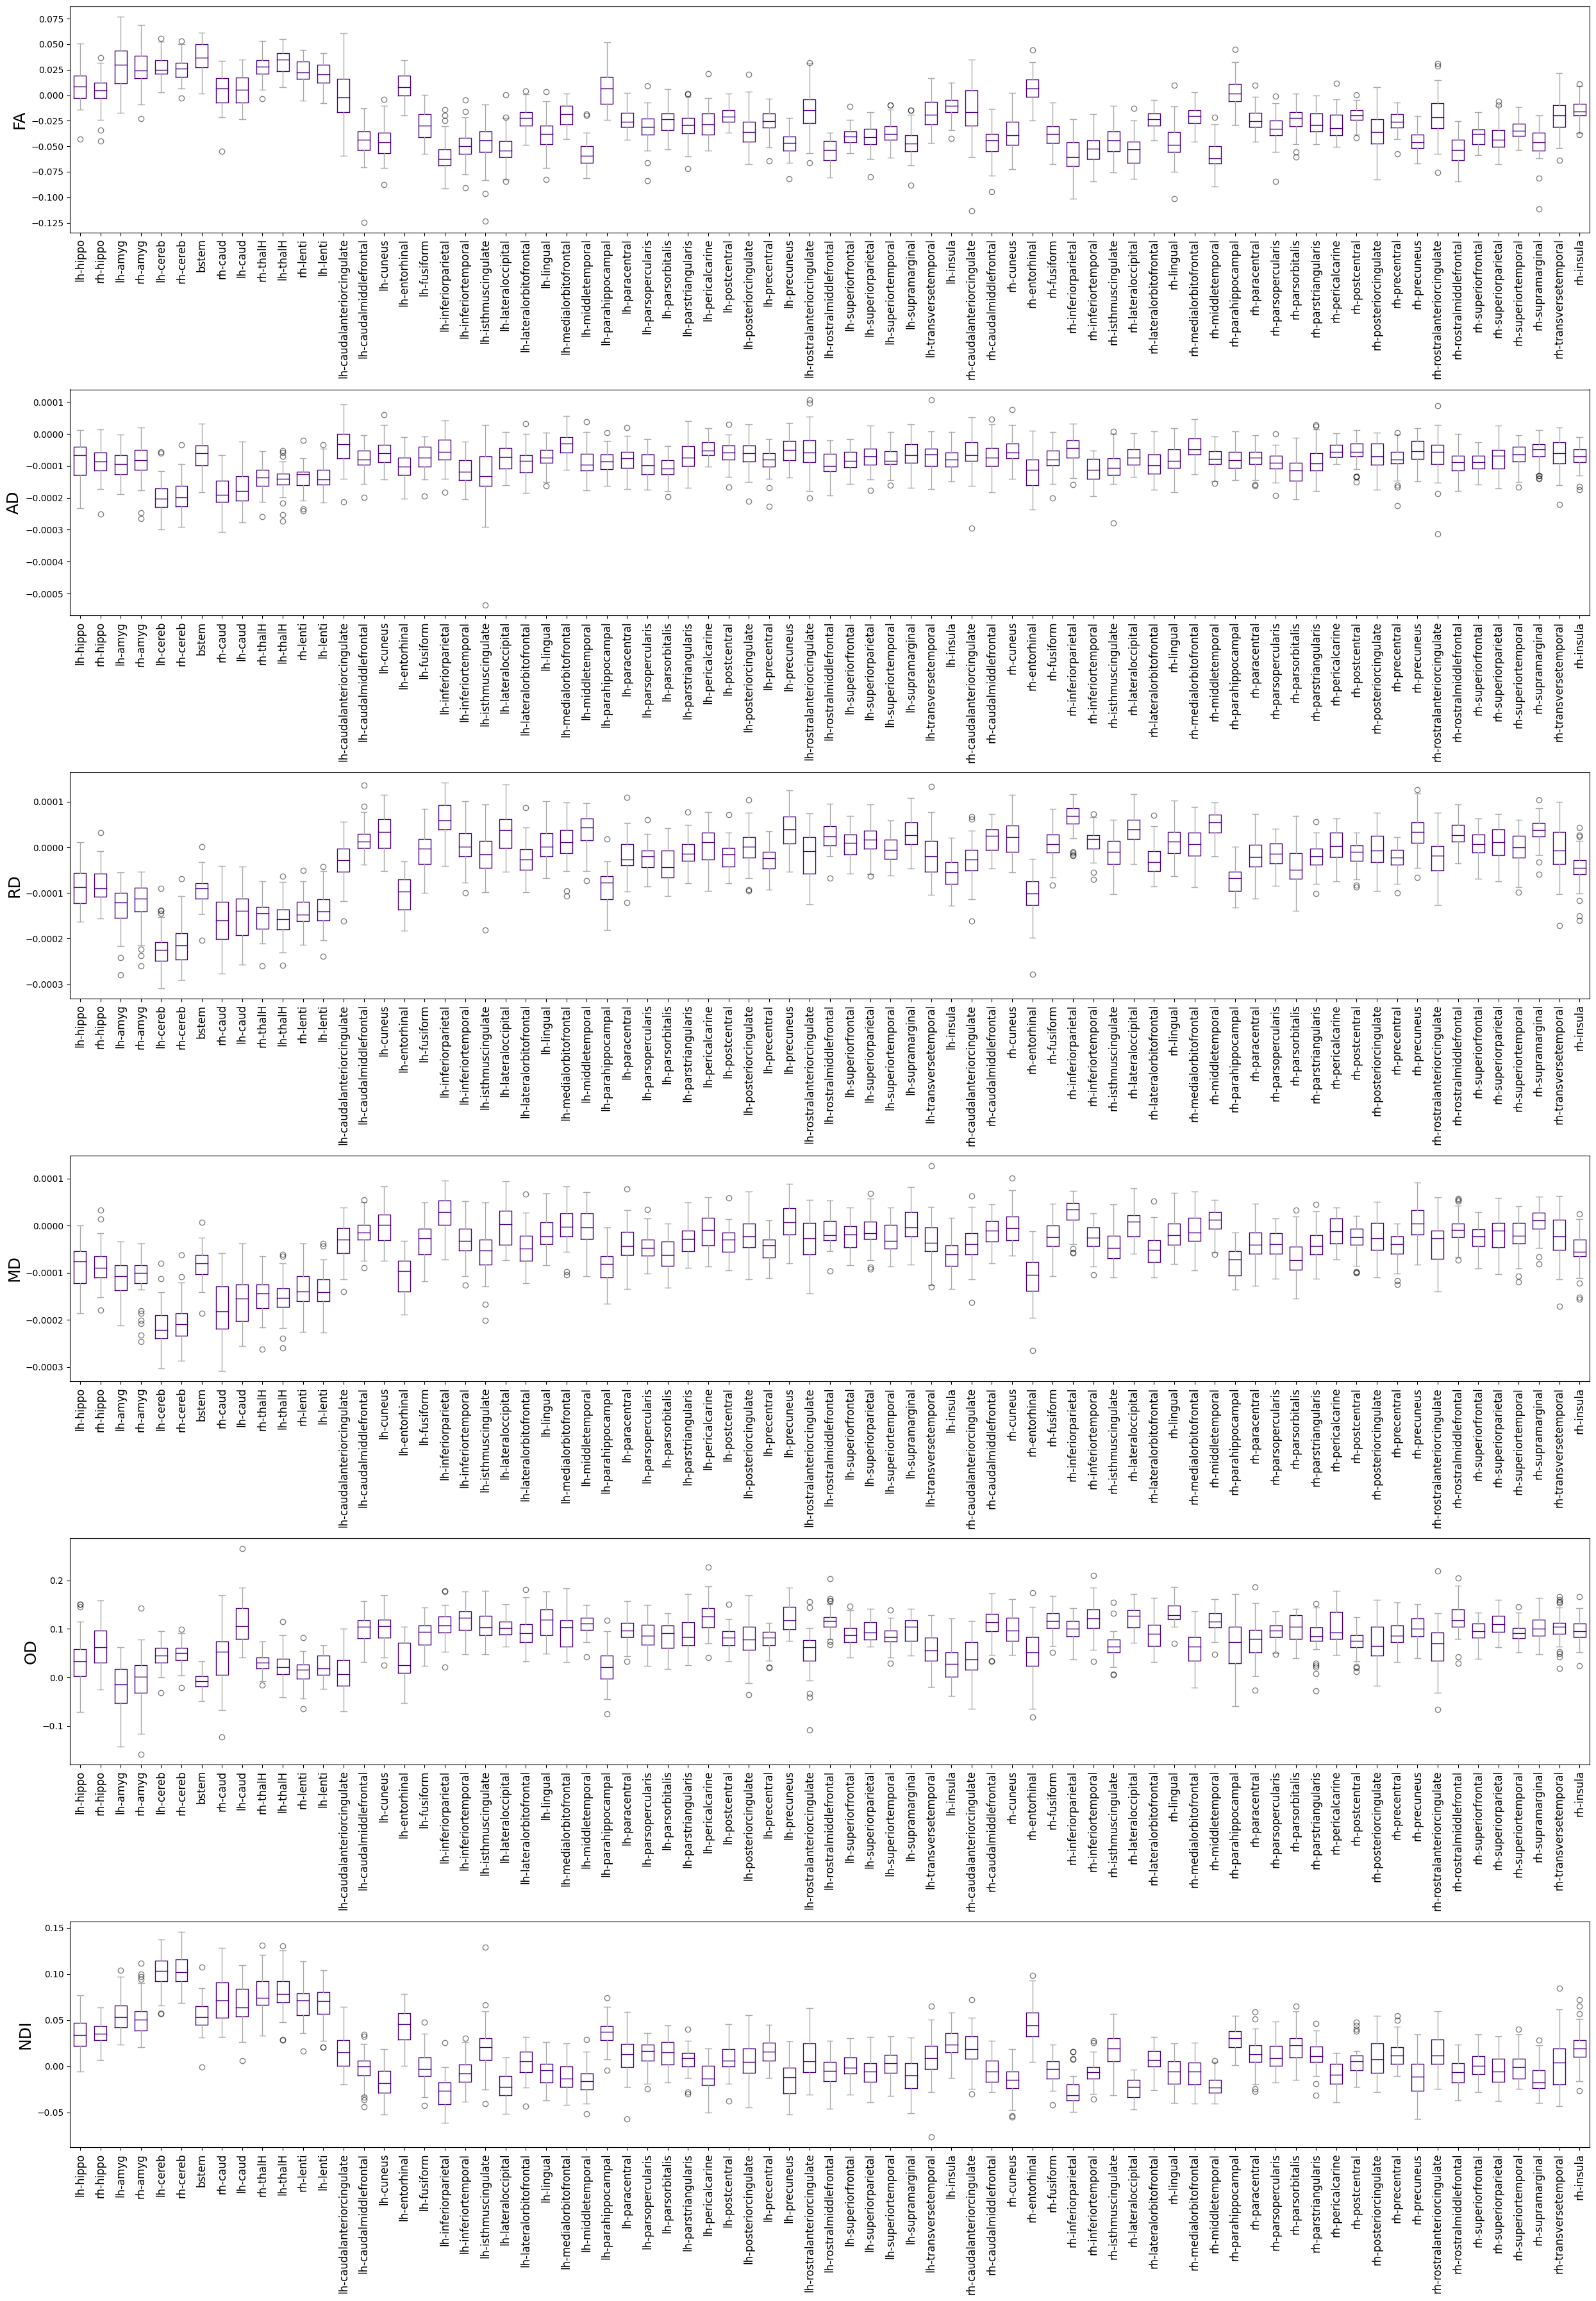

In [7]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(25, len(metrics*6)))

for r, metric in enumerate(metrics):
    for i, roi in enumerate(rois):
        sub_df = group_dif[group_dif['tract'] == roi]['dif_{}'.format(metric)].values
        
        ### correct for delay 
        corr_df = pg.linear_regression(np.array([group_dif[group_dif['tract'] == roi]['scan_delay'].values,
                                       group_dif[group_dif['tract'] == roi]['PMA_1st'].values,
                                        group_dif[group_dif['tract'] == roi]['birth_age'].values
                                       ]).T, sub_df).residuals_
        corr_df = corr_df + np.mean(sub_df)
        
        g1 = axs[r].boxplot(corr_df, positions=[i], widths=0.6)
        set_box_color(g1, 'indigo')
        
        axs[r].set_xticks(np.arange(len(rois)), relabeled_encoding['ROI'].values, rotation=90, fontsize=12) 
        
        if metric == 'L1':
            name = 'AD'
        else: 
            name = metric
        axs[r].set_ylabel(name, fontsize=18)

plt.tight_layout()
plt.savefig('../../Results/figures/GM_correlome/regional_diffusion_difference_delay_corrected.jpg', dpi=300)
plt.show() 

In [8]:
group_dif = pd.read_csv('../../Results/extracted_metrics/GM_paper_uncorrected_ses2ses1_diff_for_ancova.csv', index_col=0)
metrics=['FA', 'L1', 'RD', 'MD', 'OD', 'NDI']
rois = relabeled_encoding['new_label'].values

dif_df = pd.DataFrame()
for i, tract in enumerate(np.unique(group_dif.tract.values)):
    sub = group_dif[group_dif.tract == tract]
    dif_df.loc[i, 'tract'] = tract
    for j,  metric in enumerate(metrics):
        ### correct for delay 
        sub_df = sub['dif_{}'.format(metric)].values
        ### correct for delay 
        corr_df = pg.linear_regression(sub['scan_delay'].values, sub_df).residuals_
        corr_df = corr_df + np.mean(sub_df)
        res = pg.wilcoxon(corr_df)
        dif_df.loc[i, metric] = res['p-val'].values[0]
        
_, p_val = pg.multicomp(dif_df[metrics].values.ravel(), method='fdr_bh')
dif_df[metrics] = np.round(p_val.reshape(np.shape(dif_df[metrics].values)),4)
#dif_df[metrics] = p_val.reshape(np.shape(dif_df[metrics].values))
dif_df['tract'] = relabeled_encoding['ROI'].values

In [9]:
group_dif = pd.read_csv('../../Results/extracted_metrics/GM_paper_uncorrected_ses2ses1_diff_for_ancova.csv', index_col=0)
metrics=['FA', 'L1', 'RD', 'MD', 'OD', 'NDI']
rois = relabeled_encoding['new_label'].values

dif_df = pd.DataFrame()
for i, tract in enumerate(np.unique(group_dif.tract.values)):
    sub = group_dif[group_dif.tract == tract]
    dif_df.loc[i, 'tract'] = tract
    for j,  metric in enumerate(metrics):
        ### correct for delay 
        sub_df = sub['dif_{}'.format(metric)].values
        ### correct for delay 
        corr_df = pg.linear_regression(sub['scan_delay'].values, sub_df).residuals_
        
        corr_df = pg.linear_regression(np.array([sub['scan_delay'].values,
                                       sub['PMA_1st'].values,
                                        sub['birth_age'].values
                                       ]).T, sub_df).residuals_
        
        corr_df = corr_df + np.mean(sub_df)
        res = pg.wilcoxon(corr_df)
        dif_df.loc[i, metric] = res['p-val'].values[0]
        
_, p_val = pg.multicomp(dif_df[metrics].values.ravel(), method='fdr_bh')
dif_df[metrics] = np.round(p_val.reshape(np.shape(dif_df[metrics].values)),4)
#dif_df[metrics] = p_val.reshape(np.shape(dif_df[metrics].values))
dif_df['tract'] = relabeled_encoding['ROI'].values

In [10]:
dif_df

,tract,FA,L1,RD,MD,OD,NDI
0,lh-hippo,0.0004,0.0,0.0000,0.0000,0.0000,0.0000
1,rh-hippo,0.0649,0.0,0.0000,0.0000,0.0000,0.0000
2,lh-amyg,0.0000,0.0,0.0000,0.0000,0.0603,0.0000
3,rh-amyg,0.0000,0.0,0.0000,0.0000,0.6487,0.0000
4,lh-cereb,0.0000,0.0,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...
70,rh-superiorparietal,0.0000,0.0,0.0873,0.0037,0.0000,0.1979
71,rh-superiortemporal,0.0000,0.0,0.8815,0.0002,0.0000,0.4261
72,rh-supramarginal,0.0000,0.0,0.0000,0.0294,0.0000,0.0000
73,rh-transversetemporal,0.0000,0.0,0.4829,0.0027,0.0000,0.5696


In [11]:
coded_df = dif_df.copy()
new_df = dif_df.copy()

for i, tract in enumerate(coded_df.tract.values):
    for j,  metric in enumerate(metrics):
        if coded_df[coded_df.tract == tract][metric].values[0] < 0.001:
            new_df.loc[i, metric] = '***'
        elif 0.001 < coded_df[coded_df.tract == tract][metric].values[0] < 0.01:
            new_df.loc[i, metric] = '**'
        elif 0.01 < coded_df[coded_df.tract == tract][metric].values[0] < 0.05:
            new_df.loc[i, metric] = '*'
        else:
            new_df.loc[i, metric] = 'n.s.'
            
new_df.to_csv('../../Results/extracted_metrics/diffusion_difference_to_0_encoded.csv')
            
#new_df['tract']  = [tract.split('-')[-1] for tract in new_df.tract.values]

### significant difference of differences 

In [12]:
metric_ar = {}

### correct for delay etc 

cor_dif = group_dif.copy()

for i, tract in enumerate(np.unique(group_dif.tract.values)):
    for j,  metric in enumerate(metrics):
        
        group_dif[group_dif.tract == tract]['dif_{}'.format(metric)].values
        
        corr = pg.linear_regression(np.array([group_dif[group_dif.tract == tract]['scan_delay'].values,
                                       group_dif[group_dif.tract == tract]['PMA_1st'].values,
                                        group_dif[group_dif.tract == tract]['birth_age'].values
                                       ]).T, 
                                 group_dif[group_dif.tract == tract]['dif_{}'.format(metric)].values).residuals_
        
        corr = corr + np.mean(group_dif[group_dif.tract == tract]['dif_{}'.format(metric)].values)
        
        cor_dif[cor_dif .tract == tract]['dif_{}'.format(metric)] = corr
        
for m,  metric in enumerate(metrics):
    metric_ar[metric] = np.zeros((len(np.unique(cor_dif.tract.values)),len(np.unique(cor_dif.tract.values)) ))
    ## combo
    for i ,tract1 in enumerate(np.unique(cor_dif.tract.values)): 
        for j ,tract2 in enumerate(np.unique(cor_dif.tract.values)):
            
            if i != j:
                a = cor_dif[cor_dif.tract == tract1]['dif_{}'.format(metric)].values
                b =cor_dif[cor_dif.tract == tract2]['dif_{}'.format(metric)].values
                #res = pg.wilcoxon(a,b)
                
                res = pg.corr(a,b)
                metric_ar[metric][i,j] = res['p-val'].values[0]
            else: 
                metric_ar[metric][i,j] = 1

/tmp/ipykernel_17338/1553806912.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_dif[cor_dif .tract == tract]['dif_{}'.format(metric)] = corr


In [19]:
m = np.array([metric_ar[metric] for metric in metrics])
shape = m.shape
_, p_vals = pg.multicomp(m.ravel(), method='fdr_bh')
m2 = p_vals.reshape(shape)

metric_ar_cor = {}
for i, metric in enumerate(metrics): 
    thr = m2[i]
    #thr[thr<0.05] = 1
    metric_ar_cor[metric] = thr

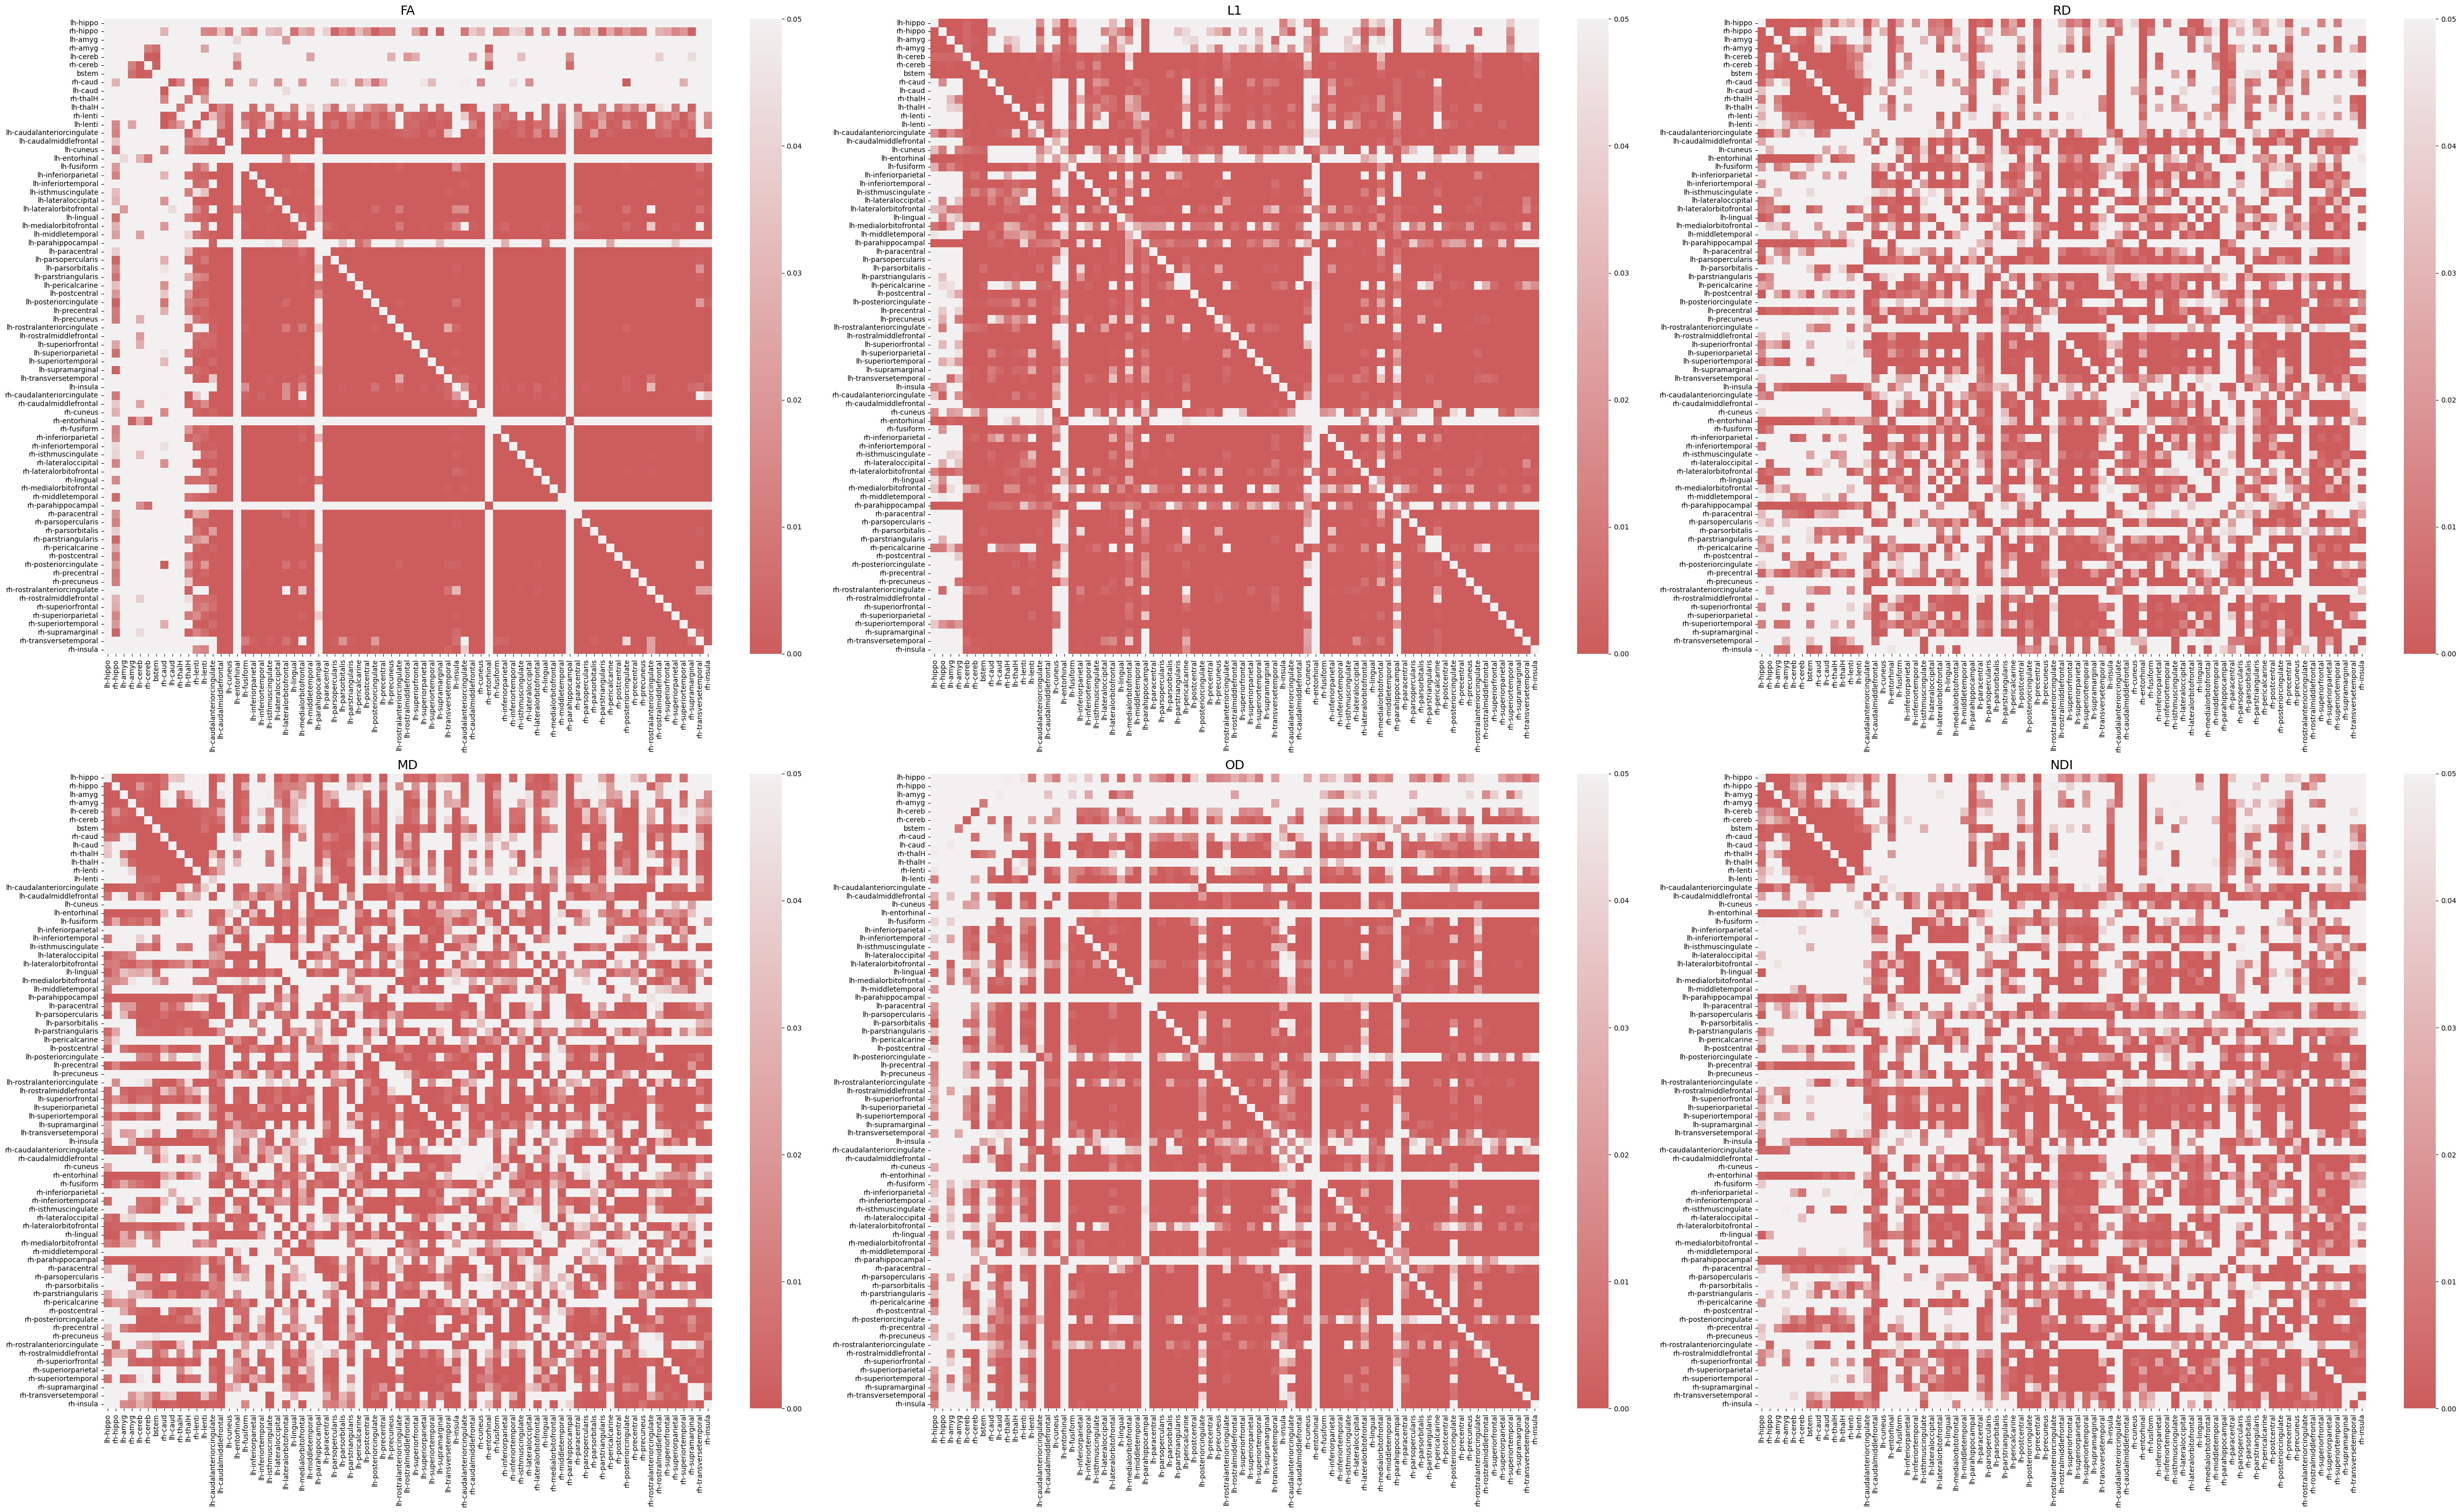

In [22]:
fig, axs = plt.subplots(2,3, figsize=(50,30))
axs = axs.ravel()
cmap = sns.light_palette('indianred', as_cmap=True).reversed()
#cmap = sns.blend_palette([ "indianred", "0.05", "white"], 2)

for i, metric in enumerate(metrics): 
    sns.heatmap(metric_ar_cor[metric], 
            xticklabels=relabeled_encoding['ROI'].values,
            yticklabels=relabeled_encoding['ROI'].values, cmap = cmap, ax=axs[i], vmin=0, vmax=0.05) 
    
    axs[i].set_title(metric, fontsize=18)
plt.tight_layout()
plt.show()

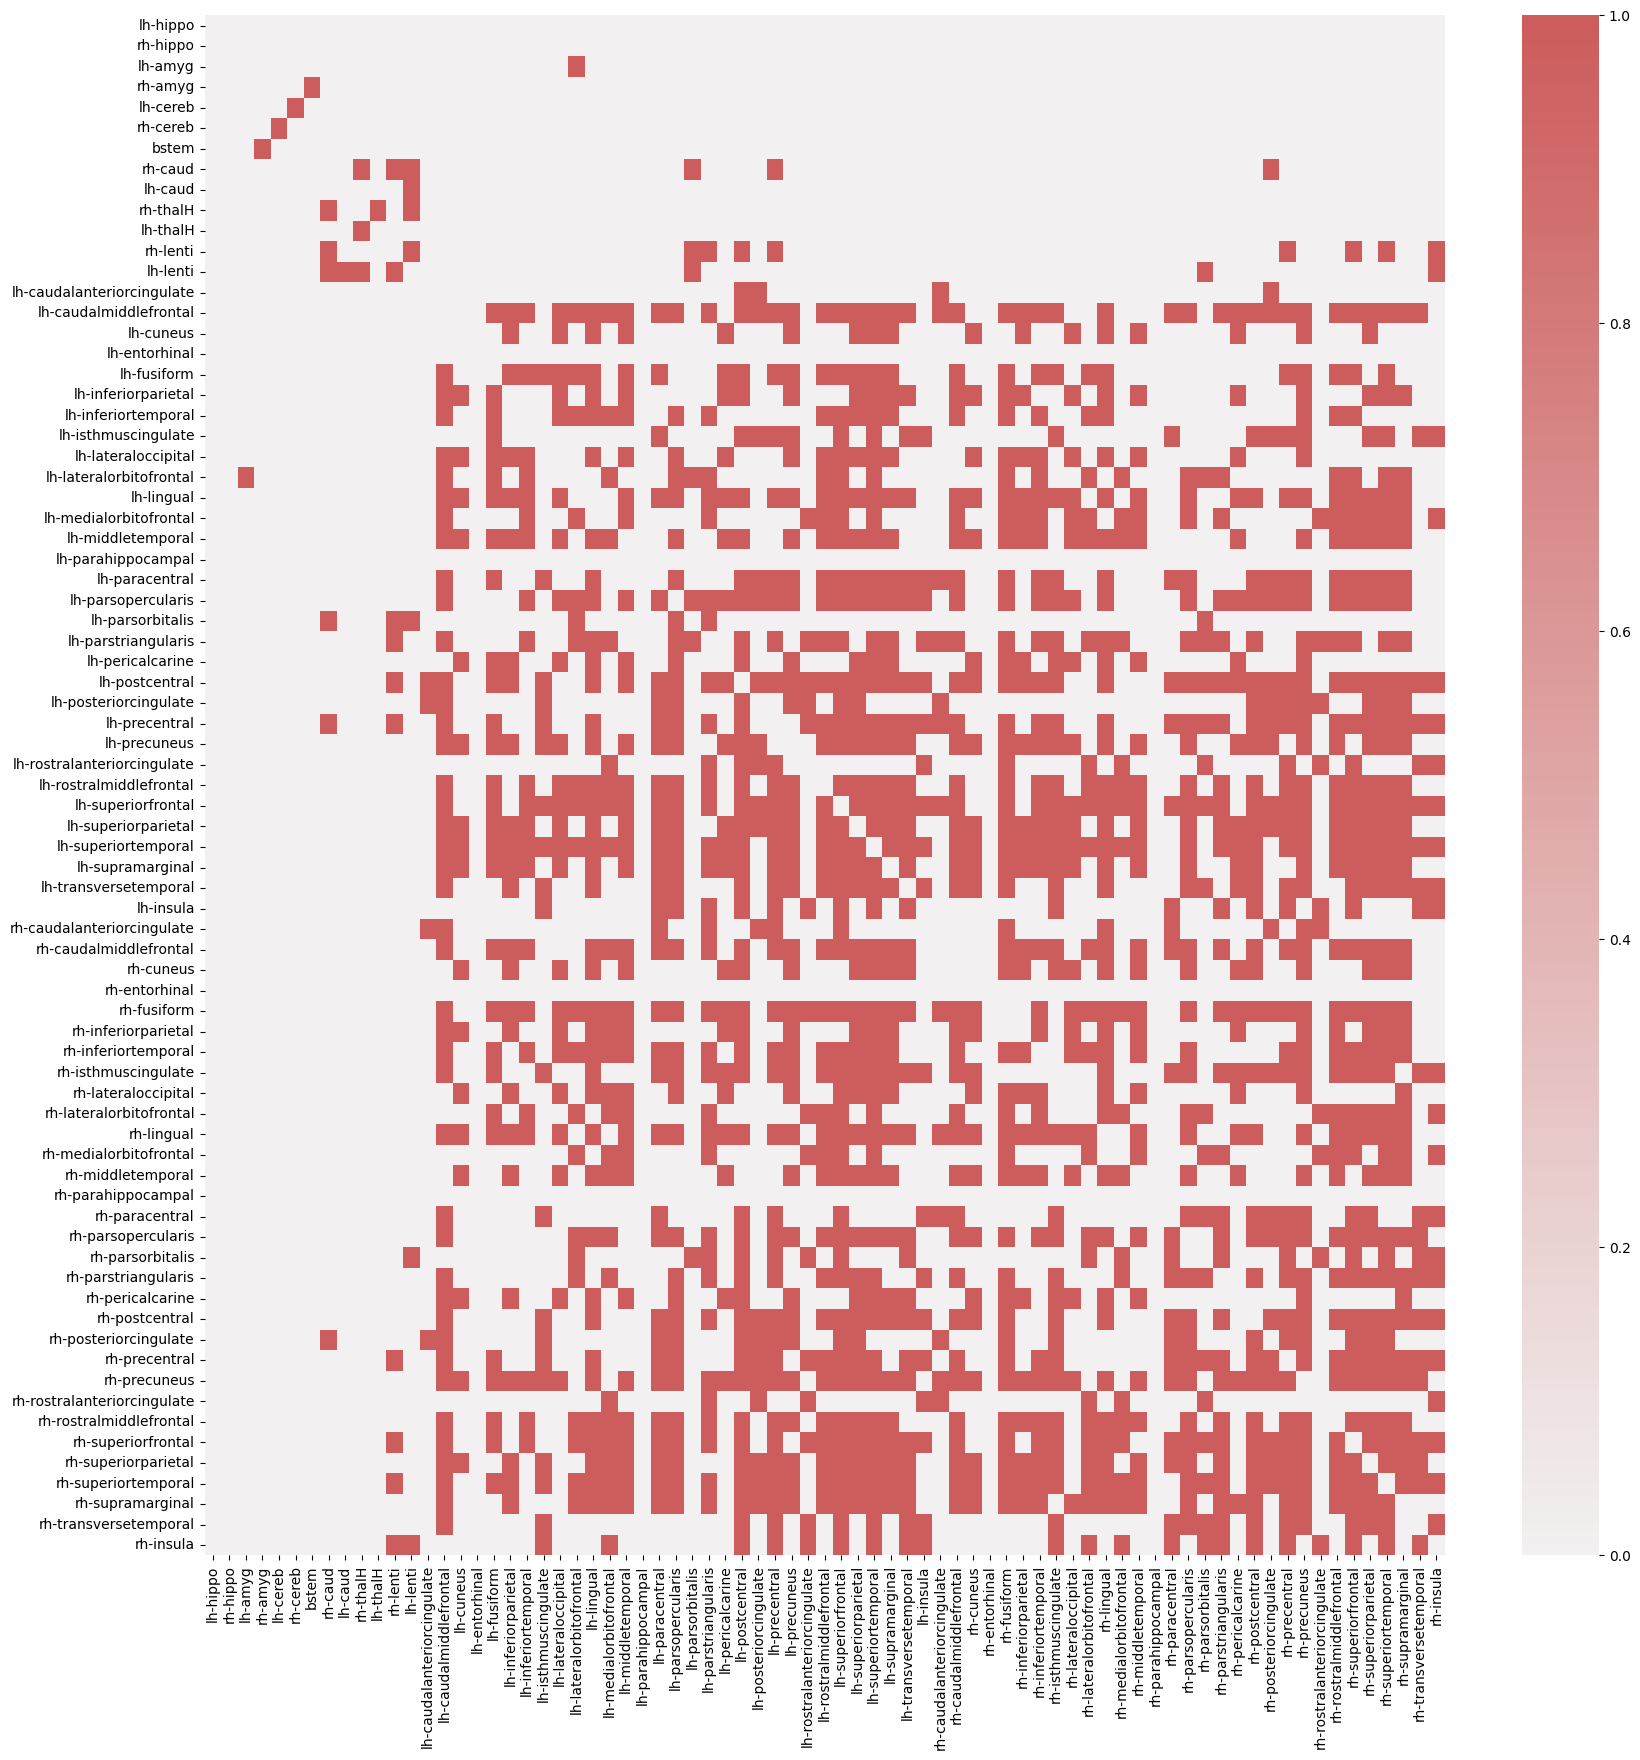

In [23]:
ar = np.array([metric_ar_cor[metric] for  metric in metrics])
binarized = np.zeros_like(ar)
binarized[ar<0.05] = 1
binarized = np.prod(binarized, axis=0)

fig, axs = plt.subplots(1,1, figsize=(20,20))
cmap = sns.light_palette('indianred', as_cmap=True)
sns.heatmap(binarized, 
            xticklabels=relabeled_encoding['ROI'].values,
            yticklabels=relabeled_encoding['ROI'].values, cmap=cmap) #, axis=axs)
plt.show()
